In [ ]:
import h5py
import zipfile
import imageio
import os
import pandas as pd

In [ ]:
from google.colab import drive

drive.mount('./mount')

Mounted at ./mount


In [ ]:
%%time

# HDF5 패키지가 위치하는 경로
hdf5_file = 'mount/My Drive/Colab Notebooks/myo_gan/crypto_dataset/cp.h5py'

# 몇개 이미지를 HDF5로 패키징할지 설정
total_images = 20000

with h5py.File(hdf5_file, 'w') as hf:

    count = 0

    with zipfile.ZipFile('mount/My Drive/Colab Notebooks/myo_gan/crypto_folder/crypto.zip', 'r') as zf:
      for i in zf.namelist():
        if (i[-4:] == '.png'):
          # 이미지 추출
          ofile = zf.extract(i)
          img = imageio.imread(ofile)
          os.remove(ofile)

          # 이미지 데이터를 HDF5 파일에 새로운 이름으로 추가
          hf.create_dataset('crypto/'+str(count)+'.png', data=img, compression="gzip", compression_opts=9)
          
          count = count + 1
          if (count%1000 == 0):
            print("images done .. ", count)
            pass
            
          # total_images 수만큼만 추가
          if (count == total_images):
            break
          pass

        pass
      pass

<timed exec>:16: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.


images done ..  1000
images done ..  2000
images done ..  3000
images done ..  4000
images done ..  5000
images done ..  6000
images done ..  7000
images done ..  8000
images done ..  9000
images done ..  10000
CPU times: user 10.6 s, sys: 1.66 s, total: 12.2 s
Wall time: 17 s


In [ ]:
# h5py를 임포트 하여 데이터 엑세스
import h5py

import numpy
import matplotlib.pyplot as plt

In [ ]:
# HDF5 파일을 여러서 내부 그룹을 리스팅함

with h5py.File('mount/My Drive/Colab Notebooks/myo_gan/crypto_dataset/cp.h5py', 'r') as file_object:
  
  for group in file_object:
    print(group)
    pass

crypto


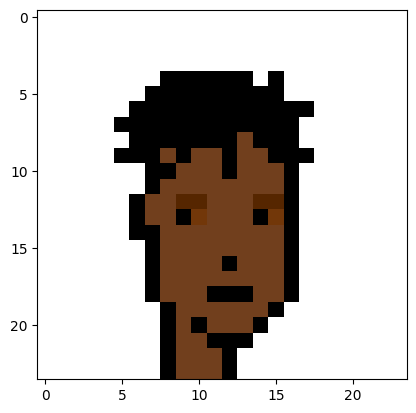

In [ ]:
# HDF5 파일을 열어서 예제 이미지를 numpy 행렬로 열고 플롯

with h5py.File('mount/My Drive/Colab Notebooks/myo_gan/crypto_dataset/cp.h5py', 'r') as file_object:
  dataset = file_object['crypto']
  image = numpy.array(dataset['8.png'])
  plt.imshow(image, interpolation='none')
  pass

In [ ]:
image.shape

(24, 24, 4)

In [ ]:
# Dataset 클래스

class CryptoDataset(dataset):
    
    def __init__(self, file):
        self.file_object = h5py.File(file, 'r')
        self.dataset = self.file_object['crypto']
        pass
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, index):
        if (index >= len(self.dataset)):
          raise IndexError()
        img = numpy.array(self.dataset[str(index)+'.png'])

        return torch.cuda.FloatTensor(img).permute(2,0,1).view(1,4,24,24) / 255.0
    
    def plot_image(self, index):
        img = numpy.array(self.dataset[str(index)+'.png'])

        plt.imshow(img, interpolation='nearest')
        pass
    
    pass

TypeError: ignored

In [ ]:
crypto_dataset = CryptoDataset('mount/My Drive/Colab Notebooks/myo_gan/crypto_dataset/cp.h5py')

crypto_dataset.plot_image(43)

NameError: ignored

In [ ]:
import torch
import torch.nn as nn

In [ ]:
class View(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape,
    
    def forward(self, x):
        return x.reshape(*self.shape)

In [ ]:
class Discriminator(nn.Module):
    
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            View(24*24*4),

            nn.Linear(4*24*24, 100),
            nn.LeakyReLU(0.02),

            nn.LayerNorm(100),

            nn.Linear(100,1),
            nn.Sigmoid()
        )

        self.loss_function = nn.BCELoss()
        self.optimiser = torch.optim.SGD(self.parameters(), lr=0.01)
        self.counter = 0
        self.progress = []

        pass
    
    
    def forward(self, inputs):
        return self.model(inputs)


    def train(self, inputs, targets):
        outputs = self.forward(inputs)
        loss = self.loss_function(outputs, targets)

        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass
        if (self.counter % 10000 == 0):
            print("counter = ", self.counter)
            pass
        
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass

    def plot_progress(self):
        df = pd.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0, 1.0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))
        pass
    
    pass

In [ ]:
def generate_random_image(size):
    random_data = torch.rand(size)
    return random_data


def generate_random_seed(size):
    random_data = torch.randn(size)
    return random_data

In [ ]:
x = generate_random_image(2)
print(x.device)

y = generate_random_seed(2)
print(y.device)

cuda:0
cuda:0


In [ ]:
%%time


D = Discriminator()
D.to(device)

for image_data_tensor in crypto_dataset:
    D.train(image_data_tensor, torch.cuda.FloatTensor([1.0]))
    D.train(generate_random_image((1,4,24,24)), torch.cuda.FloatTensor([0.0]))
    pass

counter =  10000
counter =  20000
CPU times: user 37.5 s, sys: 1.35 s, total: 38.8 s
Wall time: 40.2 s


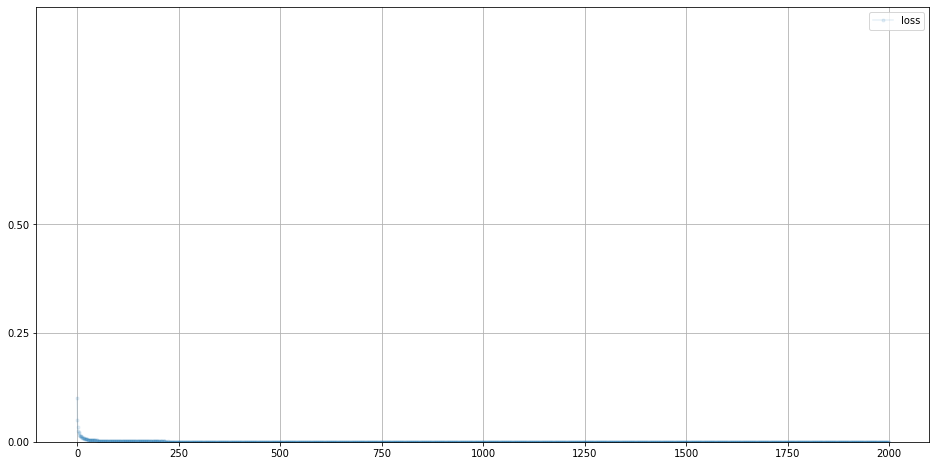

In [ ]:
D.plot_progress()

In [ ]:
class Generator(nn.Module):
    
    def __init__(self):
        # initialise parent pytorch class
        super().__init__()
        
        # define neural network layers
        self.model = nn.Sequential(
            nn.Linear(100, 3*10*10),
            nn.LeakyReLU(),
            
            nn.LayerNorm(3*10*10),
            
            nn.Linear(3*10*10, 1*4*24*24),
            
            nn.Sigmoid(),
            View((24,24,4))
        )
        
        # create optimiser, simple stochastic gradient descent
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)

        # counter and accumulator for progress
        self.counter = 0;
        self.progress = []
        
        pass
    
    
    def forward(self, inputs):        
        # simply run model
        return self.model(inputs)
    
    
    def train(self, D, inputs, targets):
        # calculate the output of the network
        g_output = self.forward(inputs)
        
        # pass onto Discriminator
        d_output = D.forward(g_output)
        
        # calculate error
        loss = D.loss_function(d_output, targets)

        # increase counter and accumulate error every 10
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass

        # zero gradients, perform a backward pass, update weights
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass
    
    
    def plot_progress(self):
        df = pd.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
        pass
    
    pass

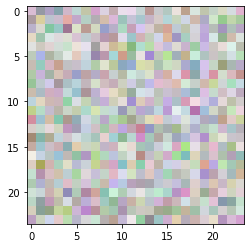

In [ ]:
G = Generator()

G.to(device)

output = G.forward(generate_random_seed(100))
img = output.detach().cpu().numpy()
plt.imshow(img, interpolation='none', cmap='Blues')

In [ ]:
%%time

D = Discriminator()
D.to(device)

G = Generator()
G.to(device)

epochs = 5

for epoch in range(epochs):
    print("epoch = ", epoch + 1)
    
    for image_data_tensor in crypto_dataset:
        D.train(image_data_tensor, torch.cuda.FloatTensor([1.0]))
        D.train(G.forward(generate_random_seed(100)).detach(), torch.cuda.FloatTensor([0.0]))
        G.train(D, generate_random_seed(100), torch.cuda.FloatTensor([1.0]))
        pass
    pass


epoch =  1
counter =  10000
counter =  20000
epoch =  2
counter =  30000
counter =  40000
epoch =  3
counter =  50000
counter =  60000
epoch =  4
counter =  70000
counter =  80000
epoch =  5
counter =  90000
counter =  100000
CPU times: user 5min 20s, sys: 12.9 s, total: 5min 33s
Wall time: 5min 32s


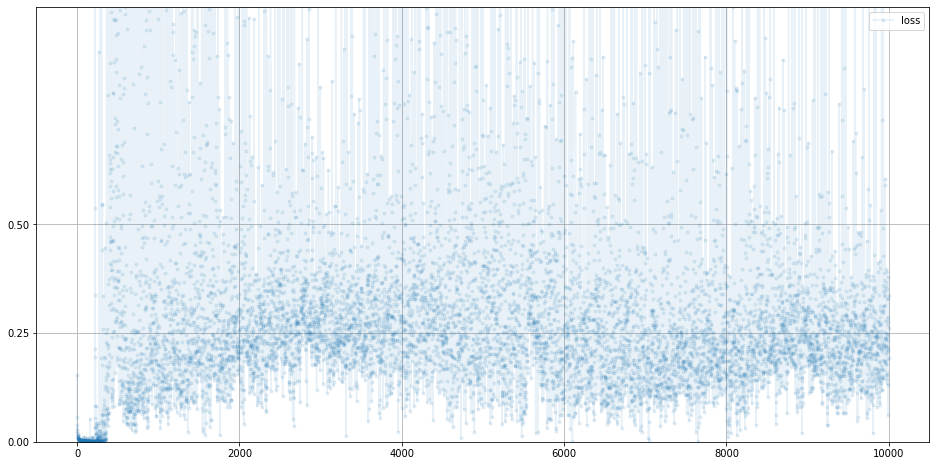

In [ ]:
D.plot_progress()

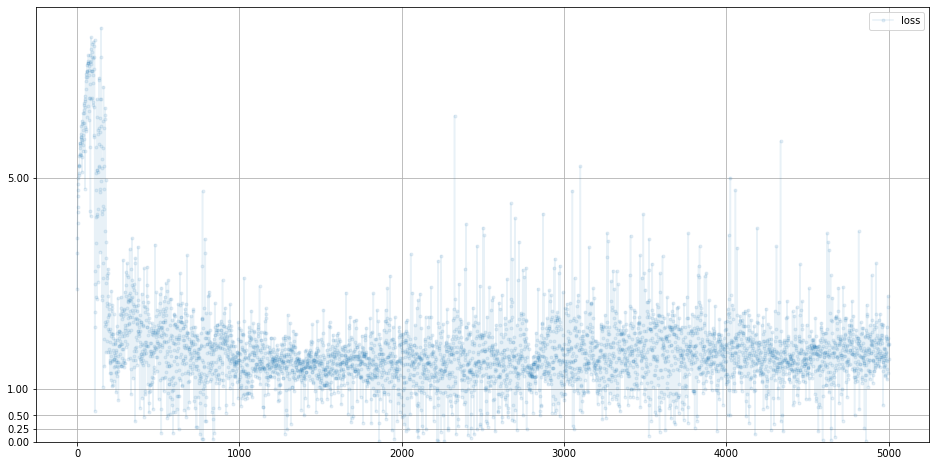

In [ ]:
G.plot_progress()

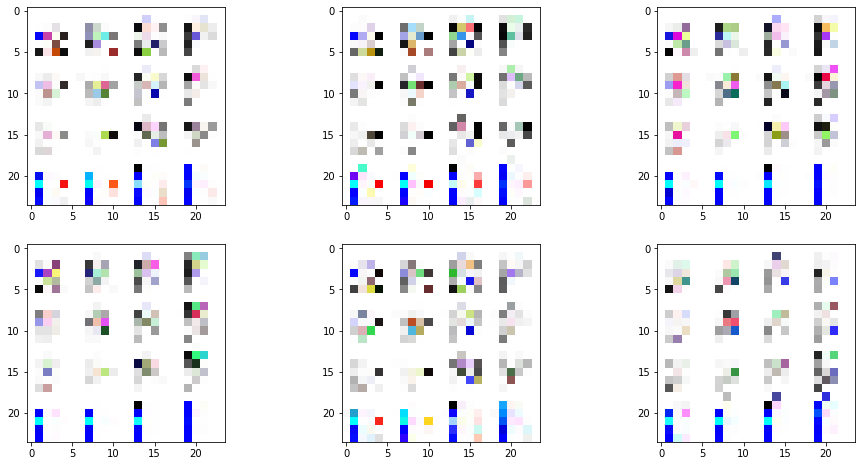

In [ ]:
f, axarr = plt.subplots(2, 3, figsize=(16,8))
for i in range(2):
    for j in range(3):
        output = G.forward(generate_random_seed(100))
        img = output.detach().cpu().numpy()
        axarr[i,j].imshow(img, interpolation='none', cmap='Blues')
        pass

    pass